5
Decision tree
0.9046920821114369
0.803030303030303
Ridge
0.8914956011730205
0.803030303030303
KNN
0.8885630498533724
0.803030303030303


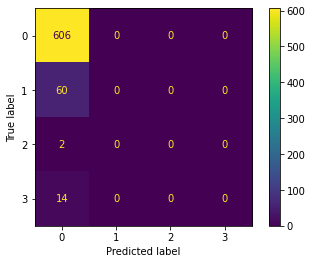

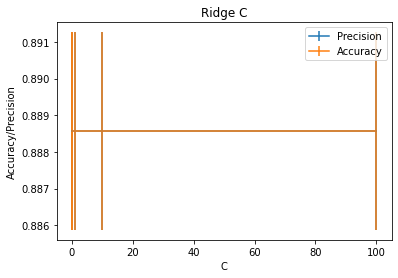

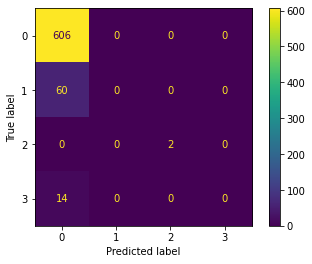

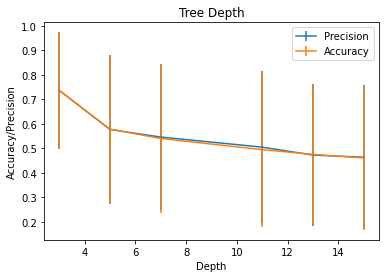

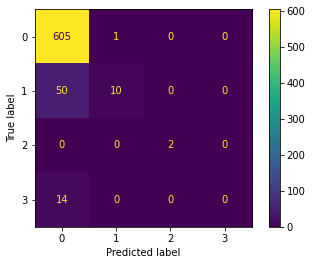

In [21]:
import pandas as pd
from sklearn import preprocessing
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import RidgeClassifier
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

UNREST_COLUMNS = ["EVENT_ID_CNTY", 
                "EVENT_DATE", 
                "EVENT_TYPE", 
                "REGION", 
                "FATALITIES",
                "TIMESTAMP"]

CASES_COLUMNS = ["iso_code",
                "continent",
                "location", 
                "date", 
                "total_cases", 
                "new_cases", 
                "total_deaths", 
                "reproduction_rate", 
                "hosp_patients", 
                "positive_rate", 
                "stringency_index", 
                "population",
                "median_age",
                "gdp_per_capita",
                "life_expectancy",
            ]

def multiPrecision(y, y_pred, **kwargs):
    return precision_score(y, y_pred, average="micro", **kwargs)

#Serialize the unique values in a dataframe column
def serialize(dataFrame, column):
    return [x for x in range(len(dataFrame[column].unique()))]

#Replace a column in a dataframe with a serialized version
def replaceDict(dataFrame, column):
    vals = serialize(dataFrame, column)
    return dict(zip(dataFrame[column].unique(), vals))

#Return rows where the specified column equals any one of the search terms
def multiSearch(df, column, searchTerms):
    if type(searchTerms) is list:
        return df.query(' | '.join(
            [f'{column} == "{term}"' for term in searchTerms]
        ))
    elif type(searchTerms) is str:
        return df.query(f'{column} == "{searchTerms}"')
    else:
        return df.query(f'{column} == {searchTerms}')

#Return rows where the specified column contains any one of the search terms
def multiContains(df, column, searchTerms):
    if type(searchTerms) is list:
        return df[df[column].str.contains('|'.join(searchTerms))]
    else:
        return df[df[column].str.contains(searchTerms)]

#Create the training data set of merged PD's and the result
def retrieveTrainingData(isoCodes):
    #Read in data from files
    unrest_df = pd.read_csv("./coronavirus_Oct31.csv")
    #Remove rows with event type of strategic developments
    unrest_df = unrest_df[unrest_df.EVENT_TYPE != 'Strategic developments']
 
    covid_cases_df = pd.read_csv("./owid-covid-data.csv")

    #Filter columns that wont be used as features
    unrest_df = unrest_df[unrest_df.columns.intersection(UNREST_COLUMNS)]
    covid_cases_df = covid_cases_df[covid_cases_df.columns.intersection(CASES_COLUMNS)]

    #Get data based on the input iso country codes
    unrest = multiContains(unrest_df, "EVENT_ID_CNTY", isoCodes)
    cases = multiSearch(covid_cases_df, 'iso_code', isoCodes)

    #Convert "date" type columns to dates
    unrest.EVENT_DATE = pd.to_datetime(unrest.EVENT_DATE)
    cases.date = pd.to_datetime(cases.date) 

    #Merge the two datasets with an inner join on the date fields
    merge = unrest.merge(cases, how="inner", left_on="EVENT_DATE", right_on="date")

    #Drop the iso code to avoid duplicates
    merge = merge.drop(['EVENT_ID_CNTY'], axis=1)
    #Drop remaining duplicates
    merge = merge.drop_duplicates()

    #Get the list of event types in this particular set of data
    issueType = merge['EVENT_TYPE']
    #Serialize the data and return it as the expected values for training
    issueType = issueType.replace(replaceDict(unrest_df, "EVENT_TYPE"))

    #Drop remaining unneeded data
    merge = merge.drop(['EVENT_TYPE', 'EVENT_DATE', 'REGION', 'iso_code', 'continent', 'location', 'date', 'TIMESTAMP'], axis=1).fillna(0)

    #Return
    return merge, issueType

min_max_scaler = preprocessing.MinMaxScaler()

trainingData, issueType = retrieveTrainingData(['AFG','ARG', 'BDG'])

#Normalize data between -1 and 1
trainingDataNormal = min_max_scaler.fit_transform(trainingData)
trainingDataNormal = pd.DataFrame(trainingDataNormal)

generalizedTest, issueType2 = retrieveTrainingData(['BOL'])

#Normalize data between -1 and 1
generalizedTestNormal = min_max_scaler.fit_transform(generalizedTest)
generalizedTestNormal = pd.DataFrame(generalizedTestNormal)


#Create Decision Tree Classifier
dTree = DecisionTreeClassifier(max_depth=5)
dTree.fit(trainingDataNormal, issueType)
print(dTree.get_depth())
pred = dTree.predict(trainingDataNormal)
pred2 = dTree.predict(generalizedTestNormal)
print("Decision tree")
print(precision_score(issueType, pred, average="micro"))
print(precision_score(issueType2, pred2, average="micro"))

#Create Ridge regression Classifier
ridge = RidgeClassifier()
ridge.fit(trainingDataNormal, issueType)
ridgePred = ridge.predict(trainingDataNormal)
ridgePredGen = ridge.predict(generalizedTestNormal)
print("Ridge")
print(precision_score(issueType, ridgePred, average="micro"))
print(precision_score(issueType2, ridgePredGen, average="micro"))

knn = KNeighborsClassifier(10)
knn.fit(trainingDataNormal, issueType)
ridgePred = knn.predict(trainingDataNormal)
ridgePredGen = knn.predict(generalizedTestNormal)
print("KNN")
print(precision_score(issueType, ridgePred, average="micro"))
print(precision_score(issueType2, ridgePredGen, average="micro"))
plot_confusion_matrix(knn, trainingDataNormal, issueType)
plt.show()


ridge_mean_acc = []
ridge_std_acc = []
ridge_mean_prec = []
ridge_std_prec = []
ridge_c = [0.01,0.1,1,10,100]
for C in ridge_c:
    testModel = RidgeClassifier(alpha=1/(2*C))
    tmpAcc = cross_val_score(testModel, trainingDataNormal, issueType, scoring="accuracy")
    ridge_mean_acc.append(tmpAcc.mean())
    ridge_std_acc.append(tmpAcc.std())
    tmpPrec = cross_val_score(testModel, trainingDataNormal, issueType, scoring=make_scorer(multiPrecision))
    ridge_mean_prec.append(tmpPrec.mean())
    ridge_std_prec.append(tmpPrec.std())

plt.errorbar(ridge_c, ridge_mean_prec, yerr=ridge_std_prec)
plt.errorbar(ridge_c, ridge_mean_acc, yerr=ridge_std_acc)
plt.legend(['Precision', 'Accuracy'])
plt.title("Ridge C")
plt.xlabel("C");plt.ylabel("Accuracy/Precision")
plt.show()
plot_confusion_matrix(ridge, trainingDataNormal, issueType)
plt.show()
#plot_confusion_matrix(ridge, generalizedTestNormal, issueType2)

tree_mean_acc = []
tree_std_acc = []
tree_mean_prec = []
tree_std_prec = []
tree_c = [3,5,7,11,13,15]
for C in tree_c:
    testModel = DecisionTreeClassifier(max_depth=C)
    tmpAcc = cross_val_score(testModel, trainingDataNormal, issueType, scoring="accuracy")
    tree_mean_acc.append(tmpAcc.mean())
    tree_std_acc.append(tmpAcc.std())
    tmpPrec = cross_val_score(testModel, trainingDataNormal, issueType, scoring=make_scorer(multiPrecision))
    tree_mean_prec.append(tmpPrec.mean())
    tree_std_prec.append(tmpPrec.std())

plt.errorbar(tree_c, tree_mean_prec, yerr=tree_std_prec)
plt.errorbar(tree_c, tree_mean_acc, yerr=tree_std_acc)
plt.legend(['Precision', 'Accuracy'])
plt.title("Tree Depth")
plt.xlabel("Depth");plt.ylabel("Accuracy/Precision")
plt.show()

plot_confusion_matrix(dTree, trainingDataNormal, issueType)
#plot_confusion_matrix(dTree, generalizedTestNormal, issueType2)

5
Decision tree
0.643090909090909
Ridge
0.612


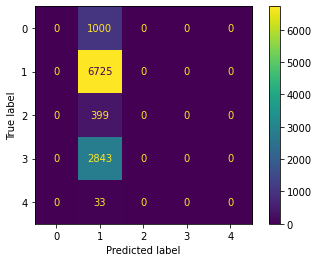

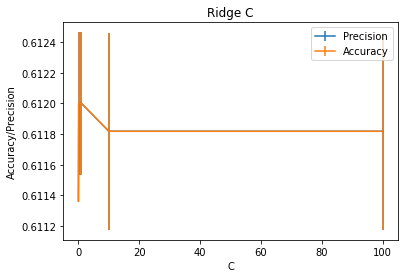

KNN
0.6687272727272727


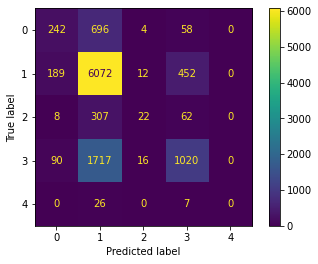

In [34]:
import pandas as pd
from sklearn import preprocessing
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import RidgeClassifier
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

UNREST_COLUMNS = ["EVENT_ID_CNTY", 
                "EVENT_DATE", 
                "EVENT_TYPE", 
                "REGION", 
                "FATALITIES",
                "TIMESTAMP"]

CASES_COLUMNS = ["iso_code",
                "continent",
                "location", 
                "date", 
                "total_cases", 
                "new_cases", 
                "total_deaths", 
                "reproduction_rate", 
                "hosp_patients", 
                "positive_rate", 
                "stringency_index", 
                "population",
                "median_age",
                "gdp_per_capita",
                "life_expectancy",
            ]
def multiPrecision(y, y_pred, **kwargs):
    return precision_score(y, y_pred, average="micro", **kwargs)

def serialize(dataFrame, column):
    return [x for x in range(len(dataFrame[column].unique()))]

#Replace a column in a dataframe with a serialized version
def replaceDict(dataFrame, column):
    vals = serialize(dataFrame, column)
    return dict(zip(dataFrame[column].unique(), vals))

def randomSample():
    #Read in data from files
    unrest_df = pd.read_csv("./coronavirus_Oct31.csv")
    #Remove rows with event type of strategic developments
    unrest_df = unrest_df[unrest_df.EVENT_TYPE != 'Strategic developments']
 
    covid_cases_df = pd.read_csv("./owid-covid-data.csv")

    unrest_df = unrest_df[unrest_df.columns.intersection(UNREST_COLUMNS)]
    covid_cases_df = covid_cases_df[covid_cases_df.columns.intersection(CASES_COLUMNS)]
    #Get data based on the input iso country codes
    #unrest = multiContains(unrest_df, "EVENT_ID_CNTY", isoCodes)
    #cases = multiSearch(covid_cases_df, 'iso_code', isoCodes)

    #Convert "date" type columns to dates
    unrest_df.EVENT_DATE = pd.to_datetime(unrest_df.EVENT_DATE)
    covid_cases_df.date = pd.to_datetime(covid_cases_df.date) 

    #Merge the two datasets with an inner join on the date fields
    merge = unrest_df.merge(covid_cases_df, how="inner", left_on="EVENT_DATE", right_on="date")

    #Drop the iso code to avoid duplicates
    merge = merge.drop(['EVENT_ID_CNTY'], axis=1)
    #Drop remaining duplicates
    merge = merge.drop_duplicates()
    #Get the list of event types in this particular set of data
    #issueType = merge['EVENT_TYPE']
    #Serialize the data and return it as the expected values for training
    #issueType = issueType.replace(replaceDict(unrest_df, "EVENT_TYPE"))
    notPeaceful = merge[merge.EVENT_TYPE != 'Protests'].sample(10000)
    
    peaceful = merge[merge.EVENT_TYPE == 'Protests'].sample(notPeaceful.shape[0]//10)
    
    full = notPeaceful.append(peaceful)
    result = full.sample(full.shape[0])

    issueType = result['EVENT_TYPE']
    #Serialize the data and return it as the expected values for training
    issueType = issueType.replace(replaceDict(unrest_df, "EVENT_TYPE"))

    #Drop remaining unneeded data
    result = result.drop(['EVENT_TYPE', 'EVENT_DATE', 'REGION', 'iso_code', 'continent', 'location', 'date', 'TIMESTAMP'], axis=1).fillna(0)

    return result, issueType

min_max_scaler = preprocessing.MinMaxScaler()

trainingData, issueType = randomSample()

trainingDataNormal = min_max_scaler.fit_transform(trainingData)
trainingDataNormal = pd.DataFrame(trainingDataNormal)

dTree = DecisionTreeClassifier(max_depth=5)
dTree.fit(trainingDataNormal, issueType)
print(dTree.get_depth())
pred = dTree.predict(trainingDataNormal)
#pred2 = dTree.predict(generalizedTestNormal)
print("Decision tree")
print(precision_score(issueType, pred, average="micro"))
#print(precision_score(issueType2, pred2, average="micro"))

#Create Ridge regression Classifier
ridge = RidgeClassifier()
ridge.fit(trainingDataNormal, issueType)
ridgePred = ridge.predict(trainingDataNormal)
#ridgePredGen = ridge.predict(generalizedTestNormal)
print("Ridge")
print(precision_score(issueType, ridgePred, average="micro"))
#print(precision_score(issueType2, ridgePredGen, average="micro"))
ridge = RidgeClassifier(alpha=1/(2*0.01))
ridge.fit(trainingDataNormal, issueType)
plot_confusion_matrix(ridge, trainingDataNormal, issueType)
plt.show()


ridge_mean_acc = []
ridge_std_acc = []
ridge_mean_prec = []
ridge_std_prec = []
ridge_c = [0.01,0.1,1,10,100]
for C in ridge_c:
    testModel = RidgeClassifier(alpha=1/(2*C))
    tmpAcc = cross_val_score(testModel, trainingDataNormal, issueType, scoring="accuracy")
    ridge_mean_acc.append(tmpAcc.mean())
    ridge_std_acc.append(tmpAcc.std())
    tmpPrec = cross_val_score(testModel, trainingDataNormal, issueType, scoring=make_scorer(multiPrecision))
    ridge_mean_prec.append(tmpPrec.mean())
    ridge_std_prec.append(tmpPrec.std())

plt.errorbar(ridge_c, ridge_mean_prec, yerr=ridge_std_prec)
plt.errorbar(ridge_c, ridge_mean_acc, yerr=ridge_std_acc)
plt.legend(['Precision', 'Accuracy'])
plt.title("Ridge C")
plt.xlabel("C");plt.ylabel("Accuracy/Precision")
plt.show()

tree_mean_acc = []
tree_std_acc = []
tree_mean_prec = []
tree_std_prec = []
tree_c = [3,5,7,11,13,15]
'''for C in tree_c:
    testModel = DecisionTreeClassifier(max_depth=C)
    tmpAcc = cross_val_score(testModel, trainingDataNormal, issueType, scoring="accuracy")
    tree_mean_acc.append(tmpAcc.mean())
    tree_std_acc.append(tmpAcc.std())
    tmpPrec = cross_val_score(testModel, trainingDataNormal, issueType, scoring=make_scorer(multiPrecision))
    tree_mean_prec.append(tmpPrec.mean())
    tree_std_prec.append(tmpPrec.std())

plt.errorbar(tree_c, tree_mean_prec, yerr=tree_std_prec)
plt.errorbar(tree_c, tree_mean_acc, yerr=tree_std_acc)
plt.legend(['Precision', 'Accuracy'])
plt.title("Tree Depth")
plt.xlabel("Depth");plt.ylabel("Accuracy/Precision")
plt.show()
'''

knn = KNeighborsClassifier(5)
knn.fit(trainingDataNormal, issueType)
ridgePred = knn.predict(trainingDataNormal)
ridgePredGen = knn.predict(generalizedTestNormal)
print("KNN")
print(precision_score(issueType, ridgePred, average="micro"))
#print(precision_score(issueType2, ridgePredGen, average="micro"))
plot_confusion_matrix(knn, trainingDataNormal, issueType)
plt.show()
tree_mean_acc = []
tree_std_acc = []
tree_mean_prec = []
tree_std_prec = []
k = [3,5,7,11,13,15]
for C in k:
    testModel = KNeighborsClassifier(C)
    tmpAcc = cross_val_score(testModel, trainingDataNormal, issueType, scoring="accuracy")
    tree_mean_acc.append(tmpAcc.mean())
    tree_std_acc.append(tmpAcc.std())
    tmpPrec = cross_val_score(testModel, trainingDataNormal, issueType, scoring=make_scorer(multiPrecision))
    tree_mean_prec.append(tmpPrec.mean())
    tree_std_prec.append(tmpPrec.std())

plt.errorbar(tree_c, tree_mean_prec, yerr=tree_std_prec)
plt.errorbar(tree_c, tree_mean_acc, yerr=tree_std_acc)
plt.legend(['Precision', 'Accuracy'])
plt.title("Tree Depth")
plt.xlabel("Depth");plt.ylabel("Accuracy/Precision")
plt.show()